#预测罗曼商店的销售额

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics

In [155]:
train_path='./train.csv'
train=pd.read_csv(train_path)
test_path='./test.csv'
test=pd.read_csv(test_path)
train.head()

C:\Users\86155\AppData\Local\Temp\ipykernel_17132\2776537904.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train=pd.read_csv(train_path)


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [156]:
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


对比train和test数据集，发现test中缺少Sales（预测目标列）和Customers（客流量），故在train数据集中删去Customers列。
Store：商店ID
DayOfWeek：周几
Date：日期
Sales：销售额
Open：是否开业（0=歇业，1=开业）
Promo：是否在促销
StateHoliday：国定假日（a=公共假日，b=复活节，c=圣诞节，0=无）
SchoolHoliday：指示是否受公立学校关闭的影响

In [157]:
train=train.drop('Customers',axis=1)
train.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,1,1,0,1
1,2,5,2015-07-31,6064,1,1,0,1
2,3,5,2015-07-31,8314,1,1,0,1
3,4,5,2015-07-31,13995,1,1,0,1
4,5,5,2015-07-31,4822,1,1,0,1


In [158]:
store=pd.read_csv('./store.csv')
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


StoreType：商店形式（a，b，c，d）
Assortment：分类（a=basic，b=extra，c=extended）
CompetitionDistance：与最近竞争商店的距离
CompetitionOpenSinceMonth：最近竞争商店的大致开业月份
CompetitionOpenSinceYear：最近竞争商店的大致开业年份
Promo2：部分商店的持续的促销活动（0=未参与，1=正在参与）
Promo2SinceWeek：商店参与Promo2的周别
Promo2SinceYear：商店参与Promo2的年份
PromoInterval：描述Promo2开始的间隔，以开始的月份为命名

In [159]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 8 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Open           1017209 non-null  int64 
 5   Promo          1017209 non-null  int64 
 6   StateHoliday   1017209 non-null  object
 7   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 62.1+ MB


In [160]:
#连接train&store数据集
train=pd.merge(train,store,on='Store')
train.head()

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,2015-07-30,5020,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,2015-07-29,4782,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,2015-07-28,5011,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,2015-07-27,6102,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [161]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017209 entries, 0 to 1017208
Data columns (total 17 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Open                       1017209 non-null  int64  
 5   Promo                      1017209 non-null  int64  
 6   StateHoliday               1017209 non-null  object 
 7   SchoolHoliday              1017209 non-null  int64  
 8   StoreType                  1017209 non-null  object 
 9   Assortment                 1017209 non-null  object 
 10  CompetitionDistance        1014567 non-null  float64
 11  CompetitionOpenSinceMonth  693861 non-null   float64
 12  CompetitionOpenSinceYear   693861 non-null   float64
 13  Promo2      

In [162]:
#连接test&store数据集
test=pd.merge(test,store,on='Store')
test.head()

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,1,4,2015-09-17,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,857,1,3,2015-09-16,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1713,1,2,2015-09-15,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,2569,1,1,2015-09-14,1.0,1,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,3425,1,7,2015-09-13,0.0,0,0,0,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [163]:
#将数据为a、b、c、d的列数据转化为1、2、3、4
mapping={'0':0,'a':1,'b':2,'c':3,'d':4,0:0}
train['StateHoliday']=train.StateHoliday.map(mapping)
train['StoreType']=train.StoreType.map(mapping)
train['Assortment']=train.Assortment.map(mapping)
test['StateHoliday']=test.StateHoliday.map(mapping)
test['StoreType']=test.StoreType.map(mapping)
test['Assortment']=test.Assortment.map(mapping)
#根据Date列拆分年月日与星期、周别
train['Date']=pd.to_datetime(train['Date'])
train['Year']=train.Date.dt.year
train['Month']=train.Date.dt.month
train['Day']=train.Date.dt.day
train['WeekOfYear']=train.Date.dt.weekofyear
test['Date']=pd.to_datetime(test['Date'])
test['Year']=test.Date.dt.year
test['Month']=test.Date.dt.month
test['Day']=test.Date.dt.day
test['WeekOfYear']=test.Date.dt.weekofyear


C:\Users\86155\AppData\Local\Temp\ipykernel_17132\2246510437.py:14: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  train['WeekOfYear']=train.Date.dt.weekofyear
C:\Users\86155\AppData\Local\Temp\ipykernel_17132\2246510437.py:19: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  test['WeekOfYear']=test.Date.dt.weekofyear


原代码mapping={'0':0,'a':1,'b':2,'c':3,'d':4}映射后该列出现大量空值
使用train['StateHoliday'].unique()查看发现StateHoliday列中有两种格式的0：'0'和0
修改为mapping={'0':0,'a':1,'b':2,'c':3,'d':4,0:0}
空值消失

发生报错：AttributeError: Can only use .dt accessor with datetimelike values
解决方法：将Date列数据转换为datetime类型

In [164]:
#促销持续时间的计算（以月为单位）
train['CompetitionOpen']=(train.Year-train.CompetitionOpenSinceYear)*12+(train.Month-train.CompetitionOpenSinceMonth)
train['PromoLast']=(train.Year-train.Promo2SinceYear)*12+(train.WeekOfYear-train.Promo2SinceWeek)/4.0
test['CompetitionOpen']=(test.Year-test.CompetitionOpenSinceYear)*12+(test.Month-test.CompetitionOpenSinceMonth)
test['PromoLast']=(test.Year-test.Promo2SinceYear)*12+(test.WeekOfYear-test.Promo2SinceWeek)/4.0
#过滤负值
train['CompetitionOpen']=train.CompetitionOpen.apply(lambda x:x if x>0 else 0)
train['PromoLast']=train.PromoLast.apply(lambda x:x if x>0 else 0)
test['CompetitionOpen']=test.CompetitionOpen.apply(lambda x:x if x>0 else 0)
test['PromoLast']=test.PromoLast.apply(lambda x:x if x>0 else 0)

In [165]:
#增加列标注是否处于促销期
train.loc[train.PromoInterval.isnull(), 'PromoInterval']=''
train['IsPromoMonth']=0
for interval in train.PromoInterval.unique():
    if interval!='':
        for month in interval.split(','):
            train.loc[(train.Month==month)&(train.PromoInterval==interval),'IsPromoMonth'] = 1

test.loc[test.PromoInterval.isnull(), 'PromoInterval']=''
test['IsPromoMonth']=0
for interval in test.PromoInterval.unique():
    if interval!='':
        for month in interval.split(','):
            test.loc[(test.Month==month)&(test.PromoInterval==interval),'IsPromoMonth'] = 1

In [166]:
#清除异常值与闭店数据（Sales<0|Open==0）
train.drop(train[(train.Sales<0)|(train.Open==0)].index)

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoLast,IsPromoMonth
0,1,5,2015-07-31,5263,1,1,0,1,3,1,...,NaN,NaN,,2015,7,31,31,82.0,0.00,0
1,1,4,2015-07-30,5020,1,1,0,1,3,1,...,NaN,NaN,,2015,7,30,31,82.0,0.00,0
2,1,3,2015-07-29,4782,1,1,0,1,3,1,...,NaN,NaN,,2015,7,29,31,82.0,0.00,0
3,1,2,2015-07-28,5011,1,1,0,1,3,1,...,NaN,NaN,,2015,7,28,31,82.0,0.00,0
4,1,1,2015-07-27,6102,1,1,0,1,3,1,...,NaN,NaN,,2015,7,27,31,82.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017202,1115,1,2013-01-07,6905,1,1,0,1,4,3,...,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,7,2,0.0,7.00,0
1017204,1115,6,2013-01-05,4771,1,0,0,1,4,3,...,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,5,1,0.0,6.75,0
1017205,1115,5,2013-01-04,4540,1,0,0,1,4,3,...,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,4,1,0.0,6.75,0
1017206,1115,4,2013-01-03,4297,1,0,0,1,4,3,...,22.0,2012.0,"Mar,Jun,Sept,Dec",2013,1,3,1,0.0,6.75,0


In [167]:
train.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2                            0
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                     0
Year                              0
Month                             0
Day                               0
WeekOfYear                        0
CompetitionOpen                   0
PromoLast                         0
IsPromoMonth                      0
dtype: int64

In [168]:
test.isnull().sum()

Id                               0
Store                            0
DayOfWeek                        0
Date                             0
Open                            11
Promo                            0
StateHoliday                     0
SchoolHoliday                    0
StoreType                        0
Assortment                       0
CompetitionDistance             96
CompetitionOpenSinceMonth    15216
CompetitionOpenSinceYear     15216
Promo2                           0
Promo2SinceWeek              17232
Promo2SinceYear              17232
PromoInterval                    0
Year                             0
Month                            0
Day                              0
WeekOfYear                       0
CompetitionOpen                  0
PromoLast                        0
IsPromoMonth                     0
dtype: int64

存在空值的列有：
CompetitionDistance
CompetitionOpenSinceMonth
CompetitionOpenSinceYear
Promo2SinceWeek
Promo2SinceYear

In [169]:
#中位数填充CompetitionDistance
train['CompetitionDistance']=train['CompetitionDistance'].fillna(train['CompetitionDistance'].quantile(0.5))

In [170]:
#test数据集中该列空值用train数据集中相应store对应的值填充
#train=train.set_index('Store')
#test=test.set_index('Store')
#test['CompetitionDistance']=test['CompetitionDistance'].fillna(train['CompetitionDistance'])

索引填充仅为思路，实际运算时间太长（>5min），未执行

CompetitionOpenSinceMonth、CompetitionOpenSinceYear可用CompetitonOpen替代
Promo2SinceWeek、Promo2SinceYear、PromoInterval可用PromoLast替代

In [171]:
#删除CompetitionOpenSinceMonth、CompetitionOpenSinceYear、Promo2SinceWeek、Promo2SinceYear列
train=train.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval'],axis=1)
test=test.drop(['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek','Promo2SinceYear','PromoInterval'],axis=1)

{'whiskers': [<matplotlib.lines.Line2D at 0x22b5ceb0970>,
 'caps': [<matplotlib.lines.Line2D at 0x22b5ceb0f10>,
 'boxes': [<matplotlib.lines.Line2D at 0x22b5ce2e290>],
 'medians': [<matplotlib.lines.Line2D at 0x22b5ceb14b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22b5ceb1780>],
 'means': []}

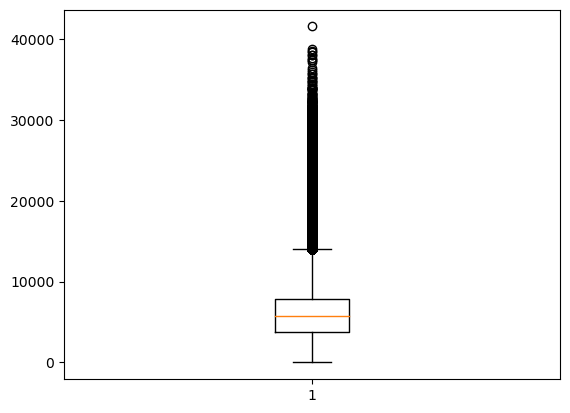

In [172]:
plt.boxplot(train['Sales'])

In [173]:
#查看异常值
train[train['Sales']==max(train['Sales'])]

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoLast,IsPromoMonth
827591,909,1,2015-06-22,41551,1,0,0,0,1,3,1680.0,1,2015,6,22,26,0.0,67.25,0


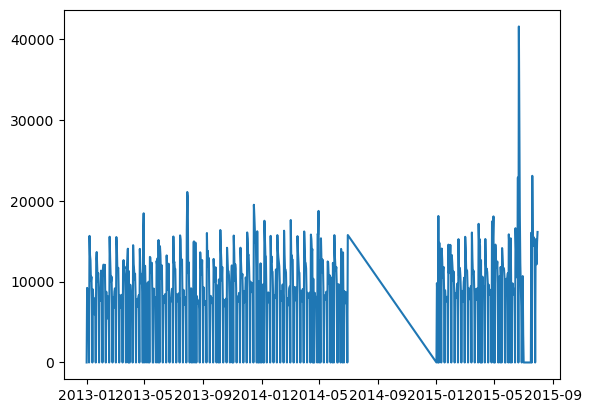

In [174]:
plt.plot('Date','Sales',data=train[train['Store']==909])

In [175]:
#非促销非节假日，该店历史销售数据波动中显示反常，删除该异常值
train=train.drop([827591])

In [176]:
#拆分训练集和测试集
y=train.Sales
x=train.drop(['Sales','Date'],axis=1)
train_X,test_X,train_Y,test_Y=train_test_split(x,y,test_size=0.25)

In [177]:
train_X=pd.DataFrame(train_X)
test_X=pd.DataFrame(test_X)
train_Y=pd.DataFrame(train_Y)
test_Y=pd.DataFrame(test_Y)

In [178]:
lgb_train = lgb.Dataset(train_X, train_Y)
lgb_eval = lgb.Dataset(test_X, test_Y, reference=lgb_train)

In [184]:
model_lgb=lgb.LGBMRegressor(objective='regression',
                            boosting_type='gbdt',
                            metric='rmse',
                            max_depth=5,
                            num_leaves=26,
                            learning_rate=0.1,
                            subsample=0.8,
                            colsample_bytree=0.5,
                            subsample_freq=5)

In [180]:
#关于lightgbm params的说明
#task:配置目标
#boosting_type:训练方式
#objective:目标
#metric:损失函数
#metric_freq:度量输出的频度
#is_training_metric:是否需要输出训练数据的度量，又称tranining_metric, train_metric
#max_bin:特征最大分割
#num_trees:树的数量
#learning_rate:学习率
#num_leaves:决策树的叶子节点数
#num_threads:最大线程个数
#feature_fraction:特值样本选取率
#bagging_freq:迭代装袋频率（每n次迭代bagging一次） 
#bagging_fraction:装袋数据选取率
#min_data_in_leaf:叶节点向下分裂的最小样本数，又称 min_data_per_leaf, min_data
#min_sum_hessian_in_leaf:叶节点的最小二阶梯度
#is_enable_sparse:是否开启稀疏优化，又称is_sparse
#use_two_round_loading:设为false更快，但数据大于内存时需设为true，又称two_round_loading, two_round 
#is_save_binary_file:是否需存为二进制文件，又称is_save_binary, save_binary

In [181]:
params_test1={'max_depth':range(3,7,1),
             'num_leaves':range(20,40,2)}
params_test2={'subsample':[0.6,0.8,1.0],
              'colsample_bytree':[0.5,0.7,0.9]}

In [182]:
gsearch=GridSearchCV(model_lgb,params_test1,
                     scoring='neg_mean_squared_error',
                     cv=5,
                     verbose=1,
                     n_jobs=-1)
gsearch.fit(x,y)
print('Best parameters found by grid search are:',gsearch.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters found by grid search are: {'max_depth': 5, 'num_leaves': 26}


In [183]:
gsearch=GridSearchCV(model_lgb,params_test2,
                     scoring='neg_mean_squared_error',
                     cv=5,
                     verbose=1,
                     n_jobs=-1)
gsearch.fit(x,y)
print('Best parameters found by grid search are:',gsearch.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters found by grid search are: {'colsample_bytree': 0.5, 'subsample': 0.8}


verbose:设置日志显示，取0不输出日志信息，取1输出带进度条的日志信息，取2输出不带进度条的日志信息。
n_jobs:任务并行时指定的CPU数量，取-1时调用全部。

In [185]:
model_lgb.fit(x,y)
y_pred=model_lgb.predict(test_X)
metrics.r2_score(test_Y,y_pred)

0.7304109007754336

In [186]:
test=test.drop(['Date'],axis=1)

In [187]:
test=pd.DataFrame(test)
predictions=model.predict(test.drop(['Id'],axis=1))

In [188]:
output=pd.DataFrame({'Id':test.Id,'Sales':predictions})
output.to_csv('Submission.csv',index=False)
print('Save successfully!')

Save successfully!
